In [110]:
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.decision_tree import *
from Functions.Models.Logistic_regression import *
from Functions.Models.evaluation import *



In [111]:
# creds_path = '/Users/gabrielabib/Desktop/NOVA_SBE/PBL/credentials.csv'
creds = pd.read_csv('/Users/gabrielabib/Desktop/NOVA_SBE/PBL/credentials.csv',sep="\t")

#Connection to the database
host = creds['Value'][0]
user = creds['Value'][1]
password = creds['Value'][2]
database = creds['Value'][3]
port = creds['Value'][4]
mydb = mysql.connector.connect(host=host, user=user, database=database, port=port, password=password, auth_plugin='mysql_native_password')
mycursor = mydb.cursor()
#Safecheck to guarantee that the connection worked
mycursor.execute('SHOW TABLES;')
print(f"Tables: {mycursor.fetchall()}")
print(mydb.connection_id) #it'll give connection_id,if got connected
alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)
alertP1

Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',)]
1589


/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,PROVENIENCIA,COD_CTH_PRIOR,CTH_PRIOR,...,DATA_MARCACAO,DATA_REALIZACAO,OBSERVACOES,Mês_entrada,Ano_entrada,trata data recusa,resume saída,mês_saida,ano_saida,Texto
0,SSHCCB,LVMVDV,LQHSOQLH,GDCADAB,3151575,USF TORRE DA MARINHA,CS/USF,CTH,3,Normal,...,21/05/2015,12/06/2015,,11,2014,21/05/2015,12/06/2015,6,2015,"Utente de 75 anos, refere tremor desde há 5 an..."
1,CSAS,LVMVBD,LOHLTRTS,FZFZSDB,3152471,USF SERVIR SAUDE-CS,CS/USF,CTH,,,...,27/04/2012,02/07/2012,,4,2012,23/04/2012,02/07/2012,7,2012,Avaliação neurologica para avaliação da toma d...
2,ADCFD,LVMMVJ,LQHROQHL,,0,,OUTRA,SAM,,,...,26/09/2014,13/01/2015,,9,2014,26/09/2014,13/01/2015,1,2015,cefaleias
3,SSZDBZ,LVMMLV,LPHQULSU,CSGGHEZ,3151672,USF AMORA SAUDAVEL,CS/USF,CTH,,,...,28/10/2013,03/12/2013,,10,2013,25/10/2013,03/12/2013,12,2013,"Utente do sexo feminino com 30 anos de idade, ..."
4,SEAHEG,LVMNDL,LPHHVHVL,,0,,OUTRA,,,,...,,,Conforme e-mail de 30/11/2015,2,2013,26/02/2013,26/02/2013,2,2013,Sem relatorio clinico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10145,GSECFZ,,LSHSRVTP,,0,,OUTRA,SON,,,...,,,doente desistiu em 26/9-voltou para Cabo Verde,9,2016,23/09/2016,23/09/2016,9,2016,
10146,GSFFSC,,LSHTPHVS,ZEHGFBSH,3151104,MIGUEL BOMBARDA,CS/USF,CTH,,,...,,,,10,2016,13/01/2017,13/01/2017,1,2017,
10147,GSCHDB,,LSHTVPOP,,0,,OUTRA,SAM,,,...,,,utente não entregou pedido SAM,11,2016,17/11/2016,17/11/2016,11,2016,
10148,GSBZAA,,LSHUQOPP,ZEESAADG,3151101,ALHOS VEDROS,CS/USF,CTH,,,...,,,,11,2016,10/02/2017,10/02/2017,2,2017,


## Connection to databse

In [112]:
#Connection to the database
# connection('/Users/gabrielabib/Desktop/NOVA_SBE/PBL/PBL-HGO/credentials.txt')

## Data cleaning

In [113]:
#changing columns with date to a datetime
date_format_alertP1(alertP1)
#change the blank values in proveniencia and priority to unknown
replace_blank(alertP1)
#create a column with the output of a referral and select the refused and accepted ones
alertP1=result(alertP1)

/Users/gabrielabib/Desktop/NOVA_SBE/PBL/PBL-HGO/Functions/AlertP1/data_cleaning.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/Users/gabrielabib/Desktop/NOVA_SBE/PBL/PBL-HGO/Functions/AlertP1/data_cleaning.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'


## Creating new columns for features 

In [114]:
class_area(alertP1)
text_length(alertP1)
referral_steps(alertP1)
alertP1=unit(alertP1)



/Users/gabrielabib/Desktop/NOVA_SBE/PBL/PBL-HGO/Functions/AlertP1/features.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['area']=['inside area' if x in area_list else 'outside area' for x in alertP1['COD_UNID_SAUDE_PROV'] ]
/Users/gabrielabib/Desktop/NOVA_SBE/PBL/PBL-HGO/Functions/AlertP1/features.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['text_length']=alertP1['Texto'].str.len()
/Users/gabrielabib/Desktop/NOVA_SBE/PBL/PBL-HGO/Functions/AlertP1/features.py:17: SettingWithCop

In [115]:
step_acceptance_rate(alertP1)

,step,number_of_acceptance,percentage
0,1,5168,66.0
1,2,936,74.0
2,3+,150,72.0


## structured data with dummies

In [116]:
data=structured_data_dummies(alertP1)
print(data.columns)
data

Index([                      'ID_DOENTE',                        'PROCESSO',
                        'COD_REFERENCIA',                          'COD_PZ',
                   'COD_UNID_SAUDE_PROV',                       'UNID_PROV',
                             'TIPO_UNID',                   'COD_CTH_PRIOR',
                             'CTH_PRIOR',               'COD_MOTIVO_RECUSA',
                     'DES_MOTIVO_RECUSA',               'COD_ESPECIALIDADE',
                            'agrupadora',                  'OUTRA_ENTIDADE',
                         'DATA_RECEPCAO',                      'DATA_ENVIO',
                          'DATA_RETORNO',                        'NUM_TAXA',
                                'ESTADO',                   'DATA_MARCACAO',
                       'DATA_REALIZACAO',                     'OBSERVACOES',
                           'Mês_entrada',                     'Ano_entrada',
                     'trata data recusa',                    'resume saída',

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,EPILEPSIA,NEUROLOGIA,NEUROLOGIA - CEFALEIAS,NEUROLOGIA - ESCLEROSE MULTIPLA,NEUROLOGIA DO COMPORTAMENTO,2,3+,HOSP,UCSP,USF
0,SSHCCB,LVMVDV,LQHSOQLH,GDCADAB,3151575,USF TORRE DA MARINHA,CS/USF,3,Normal,0,...,0,1,0,0,0,0,0,0,0,1
1,CSAS,LVMVBD,LOHLTRTS,FZFZSDB,3152471,USF SERVIR SAUDE-CS,CS/USF,,unknown,0,...,0,1,0,0,0,0,0,0,0,1
2,ADCFD,LVMMVJ,LQHROQHL,,0,,OUTRA,,unknown,0,...,1,0,0,0,0,0,0,1,0,0
3,SSZDBZ,LVMMLV,LPHQULSU,CSGGHEZ,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,1,0,0,0,0,0,0,0,1
4,SEAHEG,LVMNDL,LPHHVHVL,,0,,OUTRA,,unknown,1,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10144,GSHADS,,LSHRSQTV,ZDCECBSE,9999999,UNIDADE ALERT-P,CS/USF,,unknown,7,...,0,1,0,0,0,0,0,0,0,0
10146,GSFFSC,,LSHTPHVS,ZEHGFBSH,3151104,MIGUEL BOMBARDA,CS/USF,,unknown,7,...,0,1,0,0,0,0,0,0,0,0
10147,GSCHDB,,LSHTVPOP,,0,,OUTRA,,unknown,1,...,0,1,0,0,0,0,0,1,0,0
10148,GSBZAA,,LSHUQOPP,ZEESAADG,3151101,ALHOS VEDROS,CS/USF,,unknown,7,...,0,1,0,0,0,0,0,0,0,0


## Logistic regression for all dataset

features and coefficients

In [117]:
#split dataset in features and target variable// Question: is it the right option?
eliminate_cols=['text_length','ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns
#log_regression is defined in functions
y_pred,coefficients,intercept,X_train, X_test, y_train, y_test=log_regression(X,y)
df = pd.DataFrame(features, columns =['Feature'])
df['coefficients']=coefficients.T
df


/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,Feature,coefficients
0,outside area,-0.397390
1,SAM,0.256711
2,SON,-1.471326
3,unknown,-0.835323
4,DOENCAS DO MOVIMENTO,1.293239
5,DVC,0.004581
6,EPILEPSIA,0.689475
7,NEUROLOGIA,-3.128362
8,NEUROLOGIA - CEFALEIAS,0.031759
9,NEUROLOGIA - ESCLEROSE MULTIPLA,0.325554


metrics

Accuracy: 0.7381209503239741
Recall: 0.6140035199600202
Precision: 0.7209213279122093
              precision    recall  f1-score   support

     refused       0.70      0.28      0.40       578
    accepted       0.74      0.94      0.83      1274

    accuracy                           0.74      1852
   macro avg       0.72      0.61      0.62      1852
weighted avg       0.73      0.74      0.70      1852



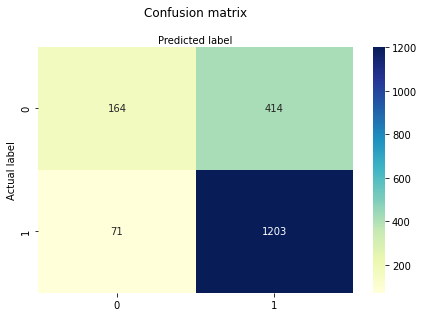

In [118]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Print the evaluation matrix
target_names = ['refused', 'accepted']
print(classification_report(y_test, y_pred, target_names=target_names))

p value

In [119]:
p_value(X,y)

,Feature,p_value
0,outside area,0.000000e+00
1,SAM,4.163195e-15
2,SON,0.000000e+00
3,unknown,0.000000e+00
4,DOENCAS DO MOVIMENTO,3.335486e-29
5,DVC,1.153450e-06
6,EPILEPSIA,3.383452e-38
7,NEUROLOGIA,0.000000e+00
8,NEUROLOGIA - CEFALEIAS,3.268588e-01
9,NEUROLOGIA - ESCLEROSE MULTIPLA,1.843868e-06


## Logistic regression text variables

In [120]:
#logistic regression text rows
data_no_text=data[data['text_length']>0]
#split dataset in features and target variable// Question: is it the right option?
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data_no_text.drop(eliminate_cols,axis=1)# Features
y = data_no_text.result # Target variable
features=X.columns
#log_regression is defined in functions
y_pred,coefficients,intercept,X_train, X_test, y_train, y_test=log_regression(X,y)
df = pd.DataFrame(features, columns =['Feature'])
df['coefficients']=coefficients.T
df

/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'st

,Feature,coefficients
0,text_length,0.001561
1,outside area,0.394206
2,SAM,-0.002987
3,SON,-0.126199
4,unknown,-0.815781
5,DOENCAS DO MOVIMENTO,1.265365
6,DVC,0.247115
7,EPILEPSIA,2.088304
8,NEUROLOGIA,-2.364998
9,NEUROLOGIA - CEFALEIAS,0.000000


metrics

Accuracy: 0.753125
Recall: 0.6776315789473684
Precision: 0.6957035558590262
              precision    recall  f1-score   support

     refused       0.58      0.50      0.54        92
    accepted       0.81      0.86      0.83       228

    accuracy                           0.75       320
   macro avg       0.70      0.68      0.68       320
weighted avg       0.74      0.75      0.75       320



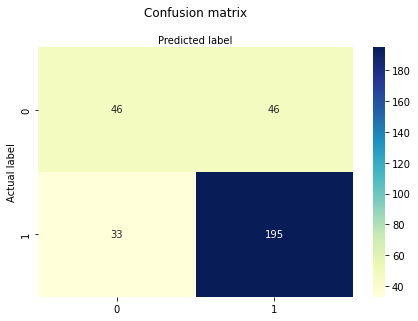

In [121]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)
# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Print the evaluation matrix
target_names = ['refused', 'accepted']
print(classification_report(y_test, y_pred, target_names=target_names))


In [122]:
p_value(X,y)

,Feature,p_value
0,text_length,2.568252e-30
1,outside area,4.194272e-27
2,SAM,1.991165e-04
3,SON,1.331836e-03
4,unknown,2.500977e-32
5,DOENCAS DO MOVIMENTO,1.173987e-06
6,DVC,4.246248e-02
7,EPILEPSIA,8.765856e-09
8,NEUROLOGIA,3.218134e-23
9,NEUROLOGIA - CEFALEIAS,5.001601e-01


In [123]:
list(X.columns)

dict_values = {'text_length' : sum(X['text_length']),'area' : sum(X[ 'outside area']),'SAM' : sum(X[ 'SAM']),'SON' : sum(X[ 'SON']),'unknown' : sum(X[ 'unknown']),'MOVIMENTO' : sum(X[ 'DOENCAS DO MOVIMENTO']),'DVC' : sum(X[ 'DVC']),'EPILEPSIA' : sum(X[ 'EPILEPSIA']),'NEUROLOGIA' : sum(X[ 'NEUROLOGIA']),'CEFALEIAS' : sum(X[ 'NEUROLOGIA - CEFALEIAS']),'MULTIPLA' : sum(X[ 'NEUROLOGIA - ESCLEROSE MULTIPLA']),'COMPORTAMENTO' : sum(X[ 'NEUROLOGIA DO COMPORTAMENTO']),'step_2' : sum(X[2]),'step_3' : sum(X[ '3+']),'HOSP' : sum(X[ 'HOSP']),'UCSP' : sum(X[ 'UCSP']),'US' : sum(X['USF'])}
dict_values

{'text_length': 740484,
 'area': 702,
 'SAM': 433,
 'SON': 29,
 'unknown': 188,
 'MOVIMENTO': 50,
 'DVC': 9,
 'EPILEPSIA': 69,
 'NEUROLOGIA': 1402,
 'CEFALEIAS': 1,
 'MULTIPLA': 7,
 'COMPORTAMENTO': 60,
 'step_2': 241,
 'step_3': 46,
 'HOSP': 651,
 'UCSP': 117,
 'US': 530}

##  Decision Tree classification model for whole dataset

/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An er

Accuracy of the train set: 0.7351511879049676
Recall of the train set: 0.6185990224728863
Precision of the train set: 0.7428442439607714
Accuracy: 0.7467602591792657
Recall: 0.6244490316313521
Precision: 0.7510123110080658


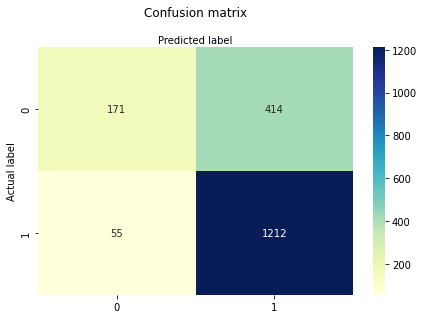

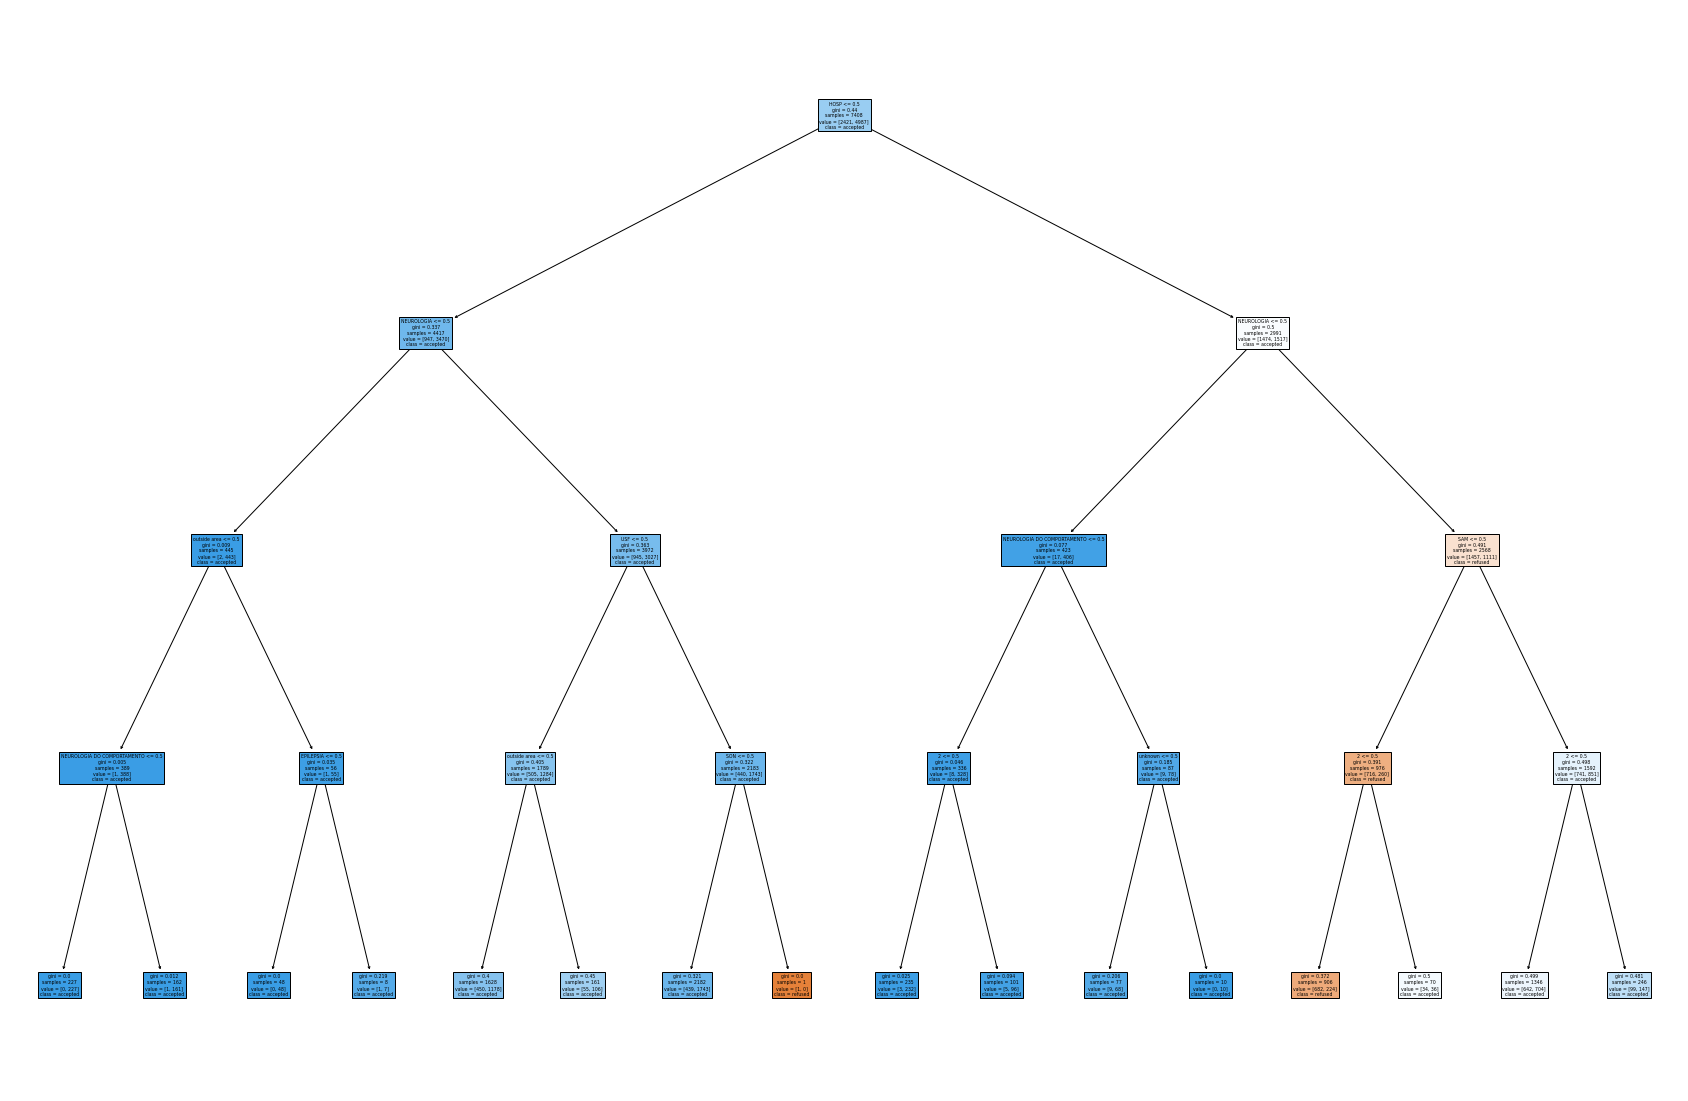

              precision    recall  f1-score   support

    accepted       0.76      0.29      0.42       585
     refused       0.75      0.96      0.84      1267

    accuracy                           0.75      1852
   macro avg       0.75      0.62      0.63      1852
weighted avg       0.75      0.75      0.71      1852



In [124]:
# Decision Tree classification model for whole dataset

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report

#split dataset in features and target variable
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto', 'text_length']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features = list(X.columns)
# feature_cols = ['text_length','outside area','SAM','SON','unknown','Other specialities']
# X = data[feature_cols] # Features
# y = data.result # Target variable

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=4, random_state = 42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the train set
accuracy = accuracy_score(y_train, clf.predict(X_train))
print("Accuracy of the train set:", accuracy)

# Evaluate the recall of the train set
recall = recall_score(y_train,clf.predict(X_train), average='macro')
print("Recall of the train set:", recall)
# Evaluate the precision of the train set
precision = precision_score(y_train, clf.predict(X_train), average='macro')
print("Precision of the train set:", precision)


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cm = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Visualize the decision tree
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names= features, class_names=['refused', 'accepted'], filled=True)
plt.show()

# Print the evaluation matrix
target_names = ['accepted', 'refused']
print(classification_report(y_test, y_pred, target_names=target_names))

## Decision Tree classification model for text rows

Accuracy of the train set: 0.7716966379984362
Recall of the train set: 0.6624298253687044
Precision of the train set: 0.7638666965678991
Accuracy: 0.753125
Recall: 0.6728686233403214
Precision: 0.7444567969859799


/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An er

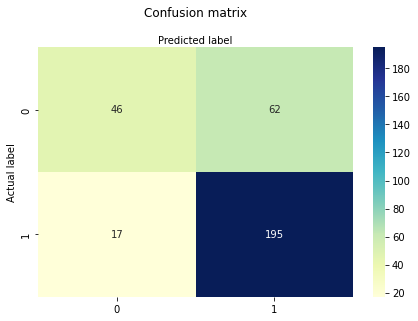

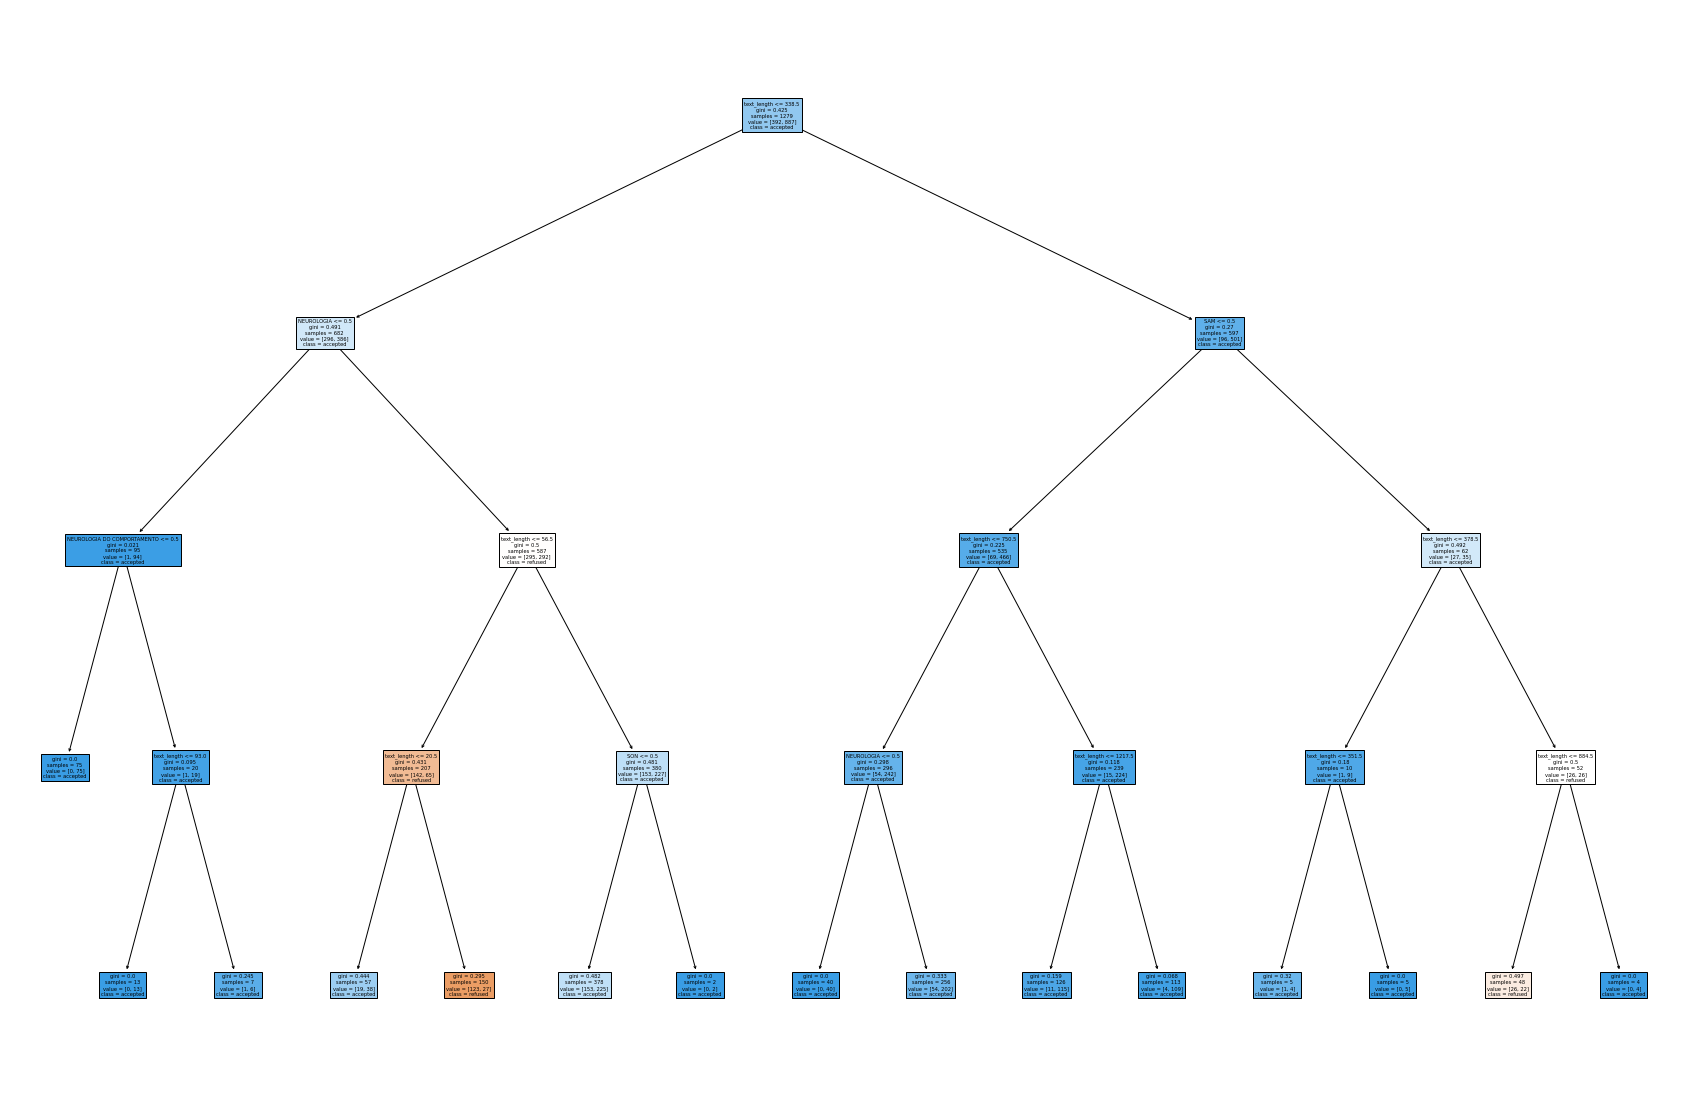

              precision    recall  f1-score   support

    accepted       0.73      0.43      0.54       108
     refused       0.76      0.92      0.83       212

    accuracy                           0.75       320
   macro avg       0.74      0.67      0.68       320
weighted avg       0.75      0.75      0.73       320



In [125]:
# Decision Tree classification model for text rows
data_no_text=data[data['text_length']>0]
#split dataset in features and target variable
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data_no_text.drop(eliminate_cols,axis=1)# Features
y = data_no_text.result # Target variable
features = list(X.columns)
# feature_cols = ['text_length','outside area','SAM','SON','unknown','Other specialities']
# X = data_no_text[feature_cols] # Features
# y = data_no_text.result # Target variable

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=4, random_state = 42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the train set
accuracy = accuracy_score(y_train, clf.predict(X_train))
print("Accuracy of the train set:", accuracy)

# Evaluate the recall of the train set
recall = recall_score(y_train,clf.predict(X_train), average='macro')
print("Recall of the train set:", recall)
# Evaluate the precision of the train set
precision = precision_score(y_train, clf.predict(X_train), average='macro')
print("Precision of the train set:", precision)


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cm = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Visualize the decision tree
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names= features, class_names=['refused', 'accepted'], filled=True)
plt.show()

# Print the evaluation matrix
target_names = ['accepted', 'refused']
print(classification_report(y_test, y_pred, target_names=target_names))

## Logistic without low p-value

In [130]:
#logistic regression text rows
data_no_text=data[data['text_length']>0]
#split dataset in features and target variable// Question: is it the right option?
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','UCSP','NEUROLOGIA - ESCLEROSE MULTIPLA','NEUROLOGIA - CEFALEIAS','3+']
X = data_no_text.drop(eliminate_cols,axis=1)# Features
y = data_no_text.result # Target variable
features=X.columns
#log_regression is defined in functions
y_pred,coefficients,intercept,X_train, X_test, y_train, y_test=log_regression(X,y)
df = pd.DataFrame(features, columns =['Feature'])
df['coefficients']=coefficients.T
df

/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'st

,Feature,coefficients
0,text_length,0.001553
1,outside area,0.343264
2,SAM,0.036044
3,SON,-0.115356
4,unknown,-0.801078
5,DOENCAS DO MOVIMENTO,1.160967
6,DVC,0.225034
7,EPILEPSIA,1.919195
8,NEUROLOGIA,-2.153942
9,NEUROLOGIA DO COMPORTAMENTO,0.649734


In [136]:
df.to_clipboard()

Accuracy: 0.753125
Recall: 0.6646643783371472
Precision: 0.695373041461621
              precision    recall  f1-score   support

     refused       0.59      0.46      0.52        92
    accepted       0.80      0.87      0.83       228

    accuracy                           0.75       320
   macro avg       0.70      0.66      0.67       320
weighted avg       0.74      0.75      0.74       320



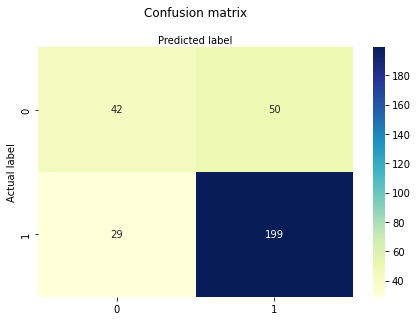

In [131]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)
# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Print the evaluation matrix
target_names = ['refused', 'accepted']
print(classification_report(y_test, y_pred, target_names=target_names))


In [138]:
p_value = p_value(X,y)
p_value.to_clipboard()
p_value

,Feature,p_value
0,text_length,2.568252e-30
1,outside area,4.194272e-27
2,SAM,1.991165e-04
3,SON,1.331836e-03
4,unknown,2.500977e-32
5,DOENCAS DO MOVIMENTO,1.173987e-06
6,DVC,4.246248e-02
7,EPILEPSIA,8.765856e-09
8,NEUROLOGIA,3.218134e-23
9,NEUROLOGIA DO COMPORTAMENTO,1.832156e-06


In [134]:
list(X.columns)

dict_values = {'text_length' : sum(X['text_length']),'area' : sum(X[ 'outside area']),'SAM' : sum(X[ 'SAM']),'SON' : sum(X[ 'SON']),'unknown' : sum(X[ 'unknown']),'MOVIMENTO' : sum(X[ 'DOENCAS DO MOVIMENTO']),'DVC' : sum(X[ 'DVC']),'EPILEPSIA' : sum(X[ 'EPILEPSIA']),'NEUROLOGIA' : sum(X[ 'NEUROLOGIA']),'COMPORTAMENTO' : sum(X[ 'NEUROLOGIA DO COMPORTAMENTO']),'step_2' : sum(X[2]),'HOSP' : sum(X[ 'HOSP']),'US' : sum(X['USF'])}
dict_values

{'text_length': 740484,
 'area': 702,
 'SAM': 433,
 'SON': 29,
 'unknown': 188,
 'MOVIMENTO': 50,
 'DVC': 9,
 'EPILEPSIA': 69,
 'NEUROLOGIA': 1402,
 'COMPORTAMENTO': 60,
 'step_2': 241,
 'HOSP': 651,
 'US': 530}

In [ ]:
['UCSP','NEUROLOGIA - ESCLEROSE MULTIPLA','NEUROLOGIA - CEFALEIAS','3+']

## Decision Tree without low p-value

/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An er

Accuracy of the train set: 0.7716966379984362
Recall of the train set: 0.6624298253687044
Precision of the train set: 0.7638666965678991
Accuracy: 0.753125
Recall: 0.6728686233403214
Precision: 0.7444567969859799


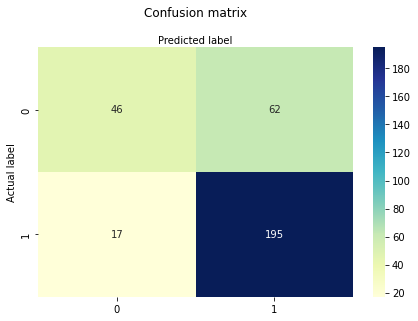

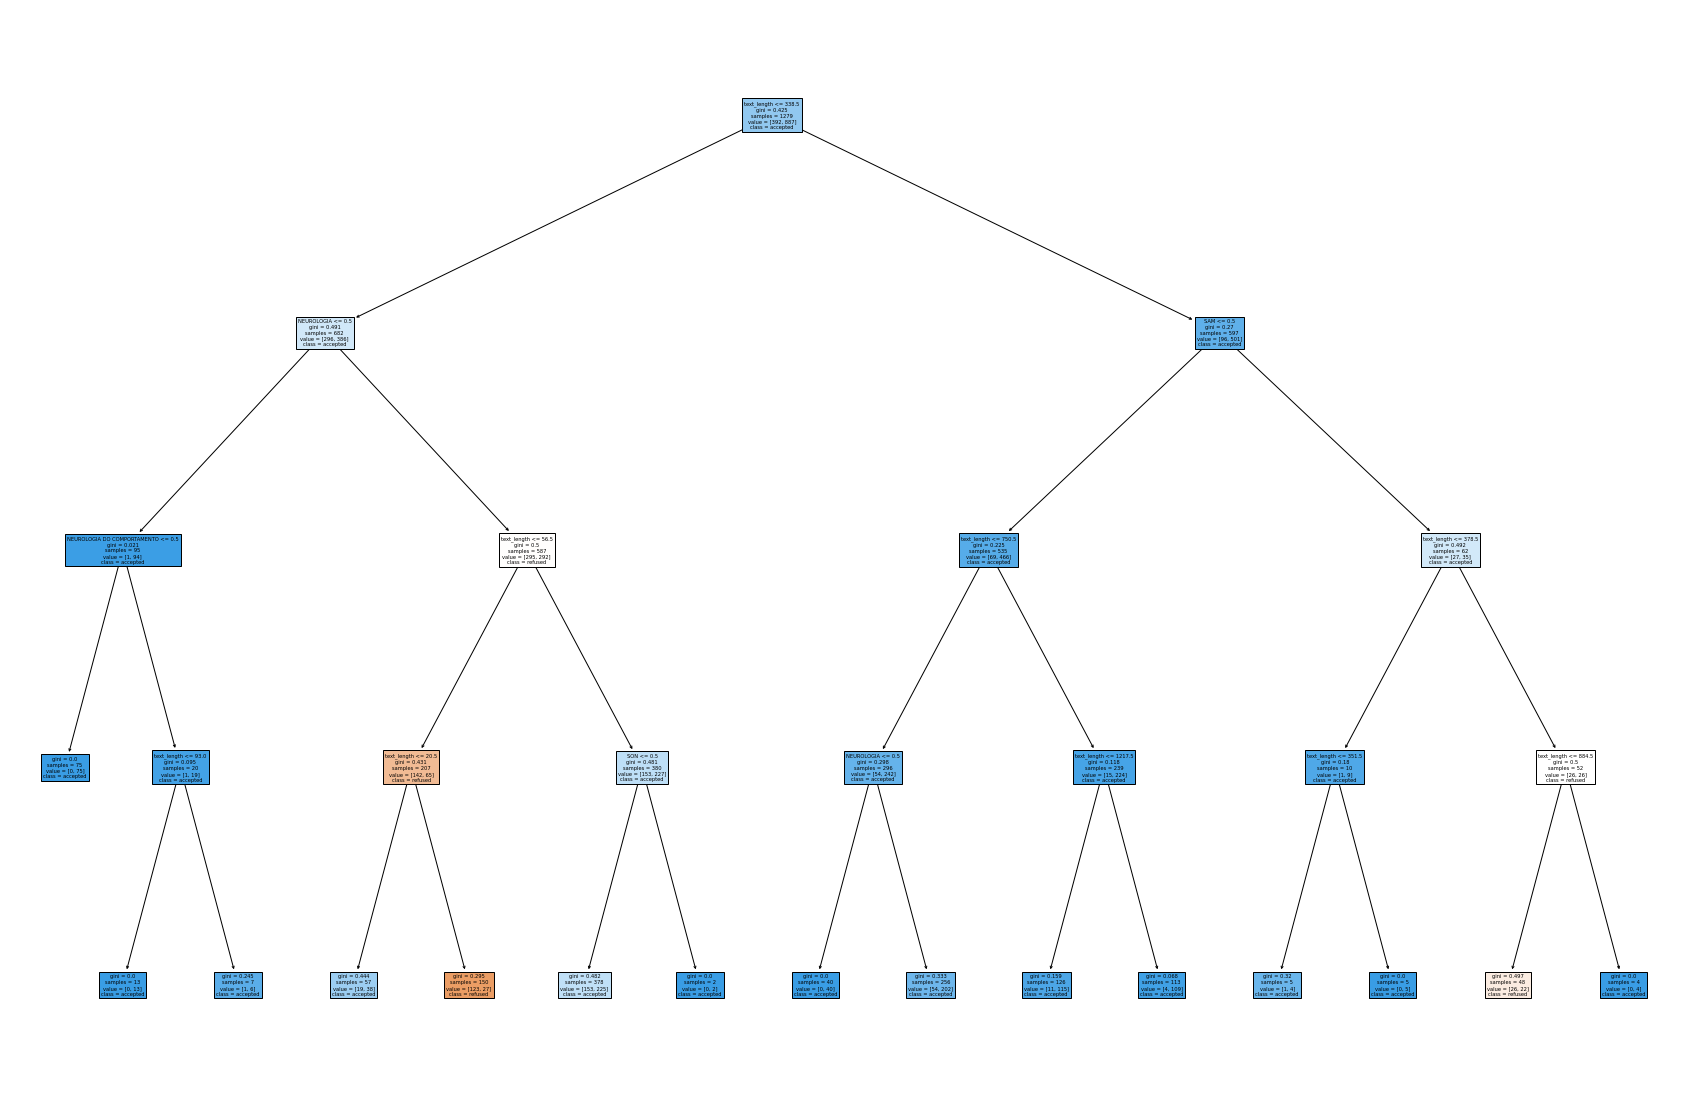

              precision    recall  f1-score   support

    accepted       0.73      0.43      0.54       108
     refused       0.76      0.92      0.83       212

    accuracy                           0.75       320
   macro avg       0.74      0.67      0.68       320
weighted avg       0.75      0.75      0.73       320



In [139]:
# Decision Tree classification model for text rows
data_no_text=data[data['text_length']>0]
#split dataset in features and target variable
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','UCSP','NEUROLOGIA - ESCLEROSE MULTIPLA','NEUROLOGIA - CEFALEIAS','3+']
X = data_no_text.drop(eliminate_cols,axis=1)# Features
y = data_no_text.result # Target variable
features = list(X.columns)
# feature_cols = ['text_length','outside area','SAM','SON','unknown','Other specialities']
# X = data_no_text[feature_cols] # Features
# y = data_no_text.result # Target variable

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=4, random_state = 42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the train set
accuracy = accuracy_score(y_train, clf.predict(X_train))
print("Accuracy of the train set:", accuracy)

# Evaluate the recall of the train set
recall = recall_score(y_train,clf.predict(X_train), average='macro')
print("Recall of the train set:", recall)
# Evaluate the precision of the train set
precision = precision_score(y_train, clf.predict(X_train), average='macro')
print("Precision of the train set:", precision)


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cm = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Visualize the decision tree
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names= features, class_names=['refused', 'accepted'], filled=True)
plt.show()

# Print the evaluation matrix
target_names = ['accepted', 'refused']
print(classification_report(y_test, y_pred, target_names=target_names))